In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
from scipy.optimize import curve_fit
import matplotlib.pylab as pylab
from scipy.stats import iqr


In [12]:
def pb(x0,L):
	return((x0+L)%L)


class ant():
    
    def __init__(self,ids,y=0,flowc=0,stoppedc=0,cari=0,laneint=0):
        col=['ro','bo','go']
        self.x=np.random.uniform(0,L)
        self.y=y
        self.xunp=self.x
        self.v=np.random.uniform(0,1)
        self.dt=.05
        self.tau=1.0
        self.v_pref=29#+min(np.random.normal(0,6.7),6.7)
        self.R=29*2
        self.r=4.5
        self.ids=ids
        self.stopped=0
        self.laneint=col[laneint]
        #print(cari)
        if (cari>=flowc):   
            #print(cari)
            self.v_pref=0  
            self.stopped=1
            self.x=500-(laneint)*8.9
                #print(stoppedc)

        self.ep=((self.v_pref)/self.tau)*(1-(self.r/self.R))**(-1.5)        
    def step(self,d=None,vbar=0,counter=0):
        if d==None:
            self.xunp=self.xunp+self.dt*self.v
            self.x=pb(self.x+self.dt*self.v,L)
            return('same')
        else:
            if d<=0:
                f=0
            else:
                if d<self.R:
                    #ep=((self.v_pref)/self.tau)*(1-(self.r/self.R))**(-1.5)
                    f=self.force(d)
                else:
                    f=0
        x0=self.x                
        self.v=max(0,self.v+self.dt*((self.v_pref -self.v)/self.tau -f))
        counter+=1
        vbar=((counter-1)*vbar+self.v)/counter
        self.xunp=self.xunp+self.dt*self.v
        self.x=pb(self.x+self.dt*self.v,L)
        return(vbar,counter)
    def force(self,x):
        f=self.ep*(1-(x/self.R))**(1.5)
        if type(f)!=complex:
            return(f)
        else:
            return(0)

        
class ants():
    def __init__(self,num_ants=20,lanes=3,L=1000,flowc=0,stoppedc=0,politeness=1):
        self.lanes=lanes
        self.num_ants=num_ants
        #self.stopped=stoppedc
        self.members=[[] for i in range(lanes)]
        self.state=[[] for i in range(lanes)]
        self.vel=[[] for i in range(lanes)]
        self.ids=[[] for i in range(lanes)]
        self.xunp=[[] for i in range(lanes)]
        self.stopped=[[] for i in range(lanes)]
        self.laneint=[[] for i in range(lanes)]
        self.L=L
        self.p=politeness
        cari=0
        #meanvel=0
        for l in range(lanes):
            self.members[l]=[ant(ids=i,y=l,flowc=flowc,stoppedc=stoppedc,cari=i,laneint=l) for i in range(num_ants)]
            self.state[l]=np.array([bug.x for bug in self.members[l]])
            self.xunp[l]=np.array([bug.xunp for bug in self.members[l]])
            self.vel[l]=np.array([bug.v for bug in self.members[l]])
            self.stopped[l]=np.array([bug.stopped for bug in self.members[l]])
            self.ids[l]=np.array([i for i in range(num_ants)])
            self.laneint[l]=np.array([bug.laneint for bug in self.members[l]])
            self.members[l]=sorted(self.members[l], key=lambda bug: bug.x)
            self.counter=0
            self.vbar=0
            
            
    def step(self):
        meanvel=0
        to_switch=[[] for i in range(self.lanes)]
        for l in range(self.lanes):
        #l=np.random.choice([0,1,2])
        #a1=np.arange(len(self.members[l]))
        #random.shuffle(a1)
        
            for i in range(len(self.members[l])):
                bug=self.members[l][i]
                switchQ=False
                if bug.y==0:
                    if random.random()>.5:
                        switchQ=self.change_lanesQ(0,1,bug,i)
                    if switchQ:
                        to_switch[1].append(bug)
                elif bug.y==1:
                    lane_to_try=np.random.choice([0,2])
                    switchQ=self.change_lanesQ(1,lane_to_try,bug,i)
                    #switchQ=self.change_lanesQ(1,0,bug,a1[i])
                    if(switchQ):
                        to_switch[lane_to_try].append(bug)
                else:
                    if random.random()>.5:
                        switchQ=self.change_lanesQ(2,1,bug,i)
                    if switchQ:
                        to_switch[1].append(bug)
            
                x_b=pb(bug.x,self.L)
                x_ol=pb(self.members[l][pb(i+1,len(self.members[l]))].x,self.L)
                dx_b=min(abs(x_ol-x_b),self.L-abs(x_ol-x_b))                
                self.vbar,self.counter=bug.step(dx_b,self.vbar,self.counter)
                               
            
        for l in range(self.lanes):
            for bug in to_switch[l]:
                self.members[l].append(bug)
                self.members[bug.y].remove(bug)
                bug.y=l
        for l in range(self.lanes):
                
            self.members[l]=sorted(self.members[l],key=lambda y: y.x)
            self.state[l]=np.array([bug.x for bug in self.members[l]])
            self.xunp[l]=np.array([bug.xunp for bug in self.members[l]])
            self.vel[l]=np.array([bug.v for bug in self.members[l]])
            self.ids[l]=np.array([bug.ids for bug in self.members[l]])
            self.stopped[l]=np.array([bug.stopped for bug in self.members[l]])
            meanvel=meanvel+np.mean(self.vel[l])
            
        meanvel=meanvel/3
 
        return(meanvel)
												
    def change_lanesQ(self,current_lane,new_lane,bug,i):
        nf_index=self.find_neighbor(bug,new_lane) 
        x_b=pb(bug.x,self.L)
        x_nl=pb(self.members[new_lane][pb(nf_index+1,len(self.members[new_lane]))].x,self.L)
        x_nf=pb(self.members[new_lane][nf_index].x,self.L)
        x_ol=pb(self.members[current_lane][pb(i+1,len(self.members[current_lane]))].x,self.L)
        x_of=pb(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].x,self.L)

        #2) get relevant dx values
        #    a) get the current values
        dx_nf=min(abs(x_nl-x_nf),self.L-abs(x_nl-x_nf))
        dx_b=min(abs(x_ol-x_b),self.L-abs(x_ol-x_b))
        dx_of=min(abs(x_b-x_of),self.L-abs(x_b-x_of))
        #    b) get the values after the lane switch
        dx_bp=min(abs(x_nl-x_b),self.L-abs(x_nl-x_b))
        dx_nfp=min(abs(x_b-x_nf),self.L-abs(x_b-x_nf))
        dx_ofp=min(abs(x_ol-x_of),self.L-abs(x_ol-x_of))
        
        #3) get relevant forces
        f_current=[bug.force(dx_b)]
        f_current.append(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].force(dx_of))
        f_current.append(self.members[new_lane][nf_index].force(dx_nf))
        
        f_new=[bug.force(dx_bp)]
        f_new.append(self.members[new_lane][nf_index].force(dx_nfp))
        f_new.append(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].force(dx_ofp))
        if ((f_current[0]+self.p*(f_current[1]+f_current[2])>1*(f_new[0]+self.p*(f_new[1]+f_new[2]))) and \
            (bug.stopped==0)):
            return(True)
        return(False)
								
    def view(self,t):
        fig=plt.figure()
        plt.xlim(-1,self.L+1)
        plt.ylim(-1,2)
        line1, =plt.plot(np.arange(self.L),np.zeros(self.L),'k')
        a1='ro'
        #line2, =plt.plot([b.x for b in self.members[0]],np.zeros(len(self.members[0])),'ro')            
        line3, =plt.plot(np.arange(self.L),.5*np.ones(self.L),'k')
        #line4, =plt.plot([b.x for b in self.members[1]],.5*np.ones(len(self.members[1])),'bo')
        line5, =plt.plot(np.arange(self.L),np.ones(self.L),'k')
        #line6, =plt.plot([b.x for b in self.members[2]],np.ones(len(self.members[2])),'go')
        for l in range(0,3):
            for b in self.members[l]:
                plt.plot(b.x,np.array([1])*.5*l,b.laneint)
                if(b.stopped==1):
                    plt.plot(b.x,np.array([1])*.5*l,'ko')
        
        
        fig.savefig('./images/graph'+str(t)+'.png') #save figures
        plt.close(fig)

    def find_neighbor(self,bug,new_lane):
        x=0;i=0
        while(x<bug.x):
            try:
                x=self.members[new_lane][i].x
            except IndexError:
                return(i-1)
            i+=1
        return(i-2)

 #%%
def run():
	a1=0
#posn=np.zeros((1,3))
#dens2=np.zeros(10000)
#phi2=np.zeros(10000)
	for t in range(10000):
		meanv=my_ants.step()
#		if (t>9900):
#	a1=np.c_[my_ants.ids,my_ants.ids*0+t,my_ants.xunp]
#	posn=(np.r_[posn,a1])
		mv.append(meanv)
#			my_ants.view(t)

#		w=np.where((my_ants.state>500) &(my_ants.state<1000))[0]
#		dens2[t]=len(w)/500*1000
		if t%1000==0:
			print(t)
#return (posn)



In [13]:
L=1000
rho_a=np.linspace(0.15,.15,1)
#phi_a=np.zeros([10,10])
#vel_a=np.zeros([10,10])
#vb2=np.zeros([15,10000])
for j in range(1):
    for i,dens in enumerate(rho_a):
        print(j)
        mv=[]
        flowc=int(dens*L)
        print(flowc)
        stoppedc=0
        num_ants=stoppedc+flowc    
        my_ants=ants(num_ants=num_ants,politeness=1,flowc=flowc,stoppedc=stoppedc)
#	posn=np.zeros(num_ants)
        run()
        #phi_a[i,j]=dens*mv[-1]
        #vel_a[i,j]=mv[-1]      

0
150
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [3]:
rho_vel_phi_stop30car_p1=np.c_[rho_a,vel_a,phi_a]
#np.savetxt('rho_vel_phi_stop30car_p1_10iterations.txt',rho_vel_phi_stop30car_p1, fmt='%3.8f')

NameError: name 'rho_a' is not defined

In [29]:
#pols talk figs

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


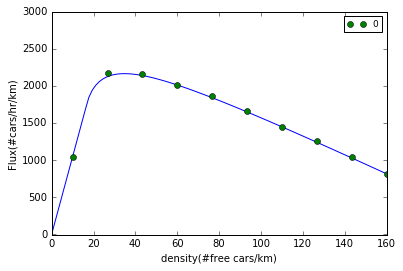

In [31]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
#l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
#l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
#plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
#l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
#plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
#plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
#plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
#plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-0.jpg',dpi=300)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


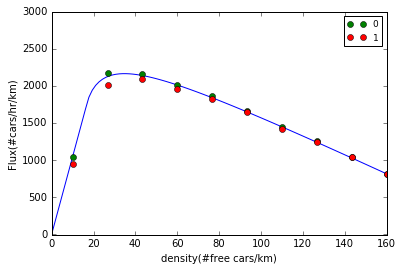

In [32]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
#l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
#plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
#l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
#plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
#plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
#plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
#plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0,l1],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-1.jpg',dpi=300)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


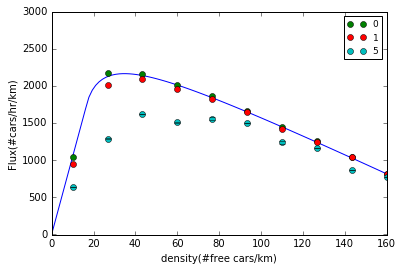

In [33]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
#l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
#plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
#plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
#plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
#plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0,l1,l5],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-5.jpg',dpi=300)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


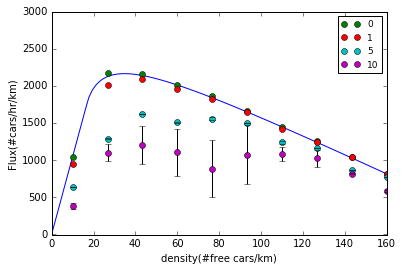

In [34]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
#plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
#plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
#plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0,l1,l5,l10],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-10.jpg',dpi=300)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


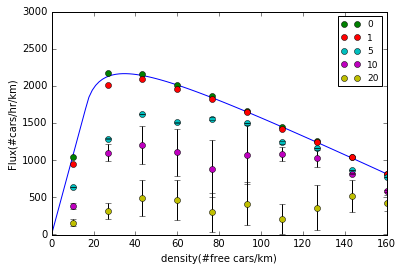

In [35]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
#plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
#plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0,l1,l5,l10,l20],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-20.jpg',dpi=300)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


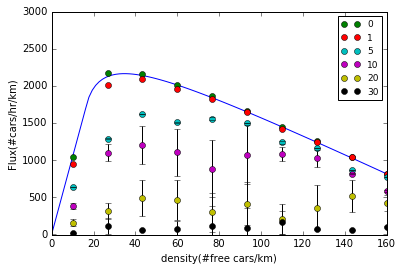

In [36]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

#l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
#plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0,l1,l5,l10,l20,l30],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-30.jpg',dpi=300)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


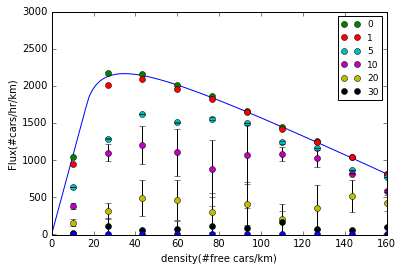

In [37]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car2_p1[:,0]*1000,rho_vel_phi_stop0car2_p1[:,2]*1000*3.6,'o',label='0')
l1,=plt.plot(rho_vel_phi_stop1car2_p1[:,0]*1000,rho_vel_phi_stop1car2_p1[:,2]*1000*3.6,'o',label='1')
l5,=plt.plot(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,'o',label='5')
plt.errorbar(rho_vel_phi_stop5car2_p1[:,0]*1000,phi_a_5sc_mean*1000*3.6,phi_a_5sc_std*1000*3.6,marker='None',linestyle='None',color='k')
l10,=plt.plot(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,'o',label='10')
plt.errorbar(rho_vel_phi_stop10car2_p1[:,0]*1000,phi_a_10sc_mean*1000*3.6,phi_a_10sc_std*1000*3.6,marker='None',linestyle='None',color='k')

l20,=plt.plot(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,'o',label='20')
plt.errorbar(rho_vel_phi_stop20car2_p1[:,0]*1000,phi_a_20sc_mean*1000*3.6,phi_a_20sc_std*1000*3.6,marker='None',linestyle='None',color='k')

l30,=plt.plot(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,'o',label='30')
plt.errorbar(rho_vel_phi_stop30car2_p1[:,0]*1000,phi_a_30sc_mean*1000*3.6,phi_a_30sc_std*1000*3.6,marker='None',linestyle='None',color='k')

l50,=plt.plot(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,'o',label='50')
plt.errorbar(rho_vel_phi_stop50car2_p1[:,0]*1000,phi_a_50sc_mean*1000*3.6,phi_a_50sc_std*1000*3.6,marker='None',linestyle='None',color='k')

plt.ylim(-10,3000)
#plt.xlim(0,200)
plt.legend(handles=[l0,l1,l5,l10,l20,l30],loc='best',prop={'size': 9})
#plt.legend(handles=[l0,l1,l5,l10,l20,l30,l50,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-stopcars_p1-50.jpg',dpi=300)

In [2]:
#matching Jesse's formula

In [3]:
1000/4.5*3

666.6666666666667

In [13]:
na=np.linspace(0,150,100)
L=1000
rhoa=na/(3*L)
r=4.5

(0, 60)

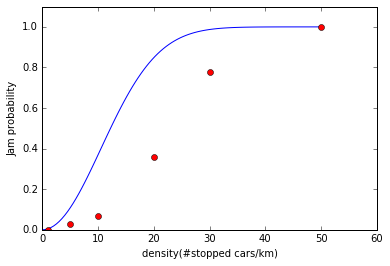

In [21]:
fig=plt.figure()
na=np.linspace(0,150,100)
L=1000
rhoa=na/(3*L)
r=4.5
plt.plot(na/3,1-(1-rhoa*r)**(rhoa*L))
plt.plot(rho_sc,prob,'ro')
plt.ylim(0,1.1)
plt.xlim(0,60)
plt.xlabel('density(#stopped cars/km)')
plt.ylabel('Jam probability')
plt.xlim(0,60)
#fig.savefig('Percolation-density-jesseformula.jpg',dpi=300)

In [53]:
N = 222;
ell = 3;
road = np.zeros([1, N*ell]);


numTries = 500;


counts = np.zeros([N*ell, numTries]);



for i in range(0,(ell*N)):
    for j in range(0,numTries):
        road = np.zeros(N*ell);
        road[:i] = np.ones(i);#road[0:i] = np.ones([1,i]);
        sh=np.arange(len(road))
        np.random.shuffle(sh)
        road=road[sh]
        road =road.reshape((N, ell));
        counts[i,j] = sum(np.sum(road,axis=1) == ell ) > 0;
        #print(sum(np.sum(road,axis=1) == ell ))
    print(i)
    
#end


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(0, 60)

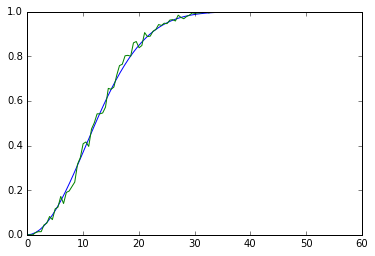

In [30]:
na=np.linspace(0,150,100)
L=1000
rhoa=na/(2*L)
r=4.5
plt.plot(na/2,1-(1-rhoa*r)**(rhoa*L))
Na = np.linspace(0,ell*N,ell*N)
#fig=plt.figure()
#plt.plot(rho_sc,prob,'ro')
plt.plot(Na/ell, np.sum(counts,axis=1)/numTries)
plt.xlim(0,60)

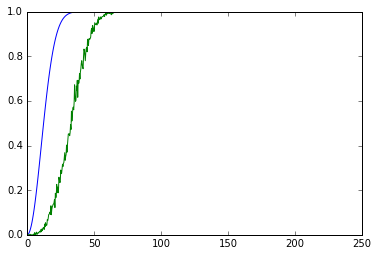

In [46]:
na=np.linspace(0,150,100)
L=1000
rhoa=na/(3*L)
r=4.5
plt.plot(na/3,1-(1-rhoa*r)**(rhoa*L))
Na = np.linspace(0,ell*N,ell*N)
#fig=plt.figure()
#plt.plot(rho_sc,prob,'ro')
plt.plot(Na/ell, np.sum(counts,axis=1)/numTries)
#plt.xlim(0,60)

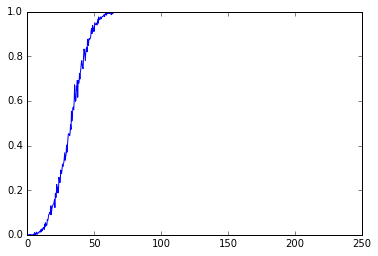

In [45]:
plt.plot(Na/ell, np.sum(counts,axis=1)/numTries)


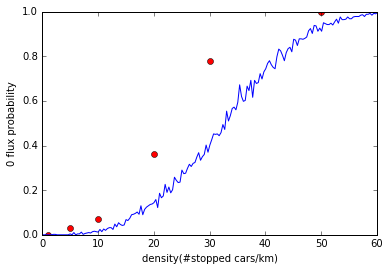

In [81]:
Na = np.linspace(0,ell*N,ell*N)
fig=plt.figure()
plt.plot(rho_sc,prob,'ro')
plt.plot(Na/ell, np.sum(counts,axis=1)/numTries)
#plt.xlim(0,60)
#plt.ylim(0,1.1)
plt.xlim(0,60)
plt.xlabel('density(#stopped cars/km)')
plt.ylabel('0 flux probability')
plt.xlim(0,60)
fig.savefig('Percolation-density-jessepermu.jpg',dpi=300)


In [51]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import comb as C #C gives "N choose k"

ell=3 #number of lanes
L=1000 #length of lane
r=4.5  #length of grid site

### useful functions, binomial distribution b, and its cumulative distribution F ###
def b(l,p,i):
    return(C(i,l,exact=False)*(p**l)*((1-p)**(i-l)))
    
def F(l,p,i):
    b_list=[b(j,p,i) for j in range(l)]
    return(sum(b_list))
    
### prob that NO column has attained l successes is F(l,p,i)^(Ncols)
P_blocked=[1-F(ell,2*r/L,i)**(L/(r)) for i in range(int(L/(r)))]

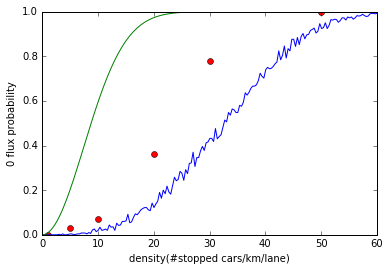

In [112]:
Na = np.linspace(0,ell*N,ell*N)
#plt.plot(P_blocked)
#plt.plot(Na/ell, np.sum(counts,axis=1)/numTries)

#fig=plt.figure()
plt.plot(rho_sc,prob,'ro')
plt.xlim(0,60)
#Na = np.linspace(0,ell*N,ell*N)
#r1=4.5
#r2=9
r=1.
plt.plot(Na/ell, np.sum(counts,axis=1)/numTries)
plt.plot(x,1-((1-4.5/1000)**(2*x*x)))

5#plt.plot(Na/ell, ((r/L*Na/ell)*(r/L*Na/ell))**(Na/ell))
#plt.plot(na/ell,1-(1-rhoa*r)**(rhoa*L))
#plt.plot([1-(((1)*(1-1*9/L)**(2*i))**(i)) for i in range(int(L/r))])
plt.xlabel('density(#stopped cars/km/lane)')
plt.ylabel('0 flux probability')
#fig.savefig('Percolation-density-David.jpg',dpi=300)


(0, 60)

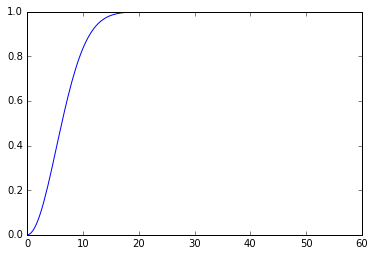

In [116]:
x=Na/ell
plt.plot(x,1-((1-2*4.5/1000)**(2*x*x)))
plt.xlim(0,60)

In [76]:
r/L*(Na/ell)

array([ 0.        ,  0.00150226,  0.00300451,  0.00450677,  0.00600902,
        0.00751128,  0.00901353,  0.01051579,  0.01201805,  0.0135203 ,
        0.01502256,  0.01652481,  0.01802707,  0.01952932,  0.02103158,
        0.02253383,  0.02403609,  0.02553835,  0.0270406 ,  0.02854286,
        0.03004511,  0.03154737,  0.03304962,  0.03455188,  0.03605414,
        0.03755639,  0.03905865,  0.0405609 ,  0.04206316,  0.04356541,
        0.04506767,  0.04656992,  0.04807218,  0.04957444,  0.05107669,
        0.05257895,  0.0540812 ,  0.05558346,  0.05708571,  0.05858797,
        0.06009023,  0.06159248,  0.06309474,  0.06459699,  0.06609925,
        0.0676015 ,  0.06910376,  0.07060602,  0.07210827,  0.07361053,
        0.07511278,  0.07661504,  0.07811729,  0.07961955,  0.0811218 ,
        0.08262406,  0.08412632,  0.08562857,  0.08713083,  0.08863308,
        0.09013534,  0.09163759,  0.09313985,  0.09464211,  0.09614436,
        0.09764662,  0.09914887,  0.10065113,  0.10215338,  0.10

In [56]:
len( np.sum(counts,axis=1)/numTries)

666

In [126]:
sh=np.arange(len(road))
np.random.shuffle(sh)
road=road[sh]

In [114]:
a1=1
print(a1==1)

True


In [75]:
print(len(road[0]))

666


In [8]:
1-(1-rhoa*r)**(rhoa*1000)

array([ 0.])

In [11]:
#checking phase transition!

In [20]:
a1=np.zeros([2,1])

In [22]:
np.shape(a1)

(2, 1)

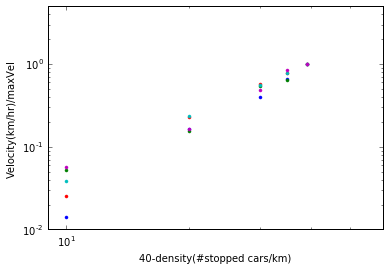

In [215]:
fig=plt.figure()
for i in range(0,5):
#i=0
    #pylab.plot(rho_sc,vel_sc[i,:]*3.6,'ro')
    pylab.loglog(40-rho_sc,vel_sc[i,:]/vel_sc[i,0],'.')
    temp=[rho_sc,vel_sc[i,:]/vel_sc[i,0]]
    a1=np.c_[a1,temp]
    #pylab.errorbar(rho_sc,vel_sc[i,:]*3.6,vel_sc_std[i,:]*3.6,linestyle='None',color='k')
plt.ylim(.01,5)
plt.xlim(9,60)
#pylab.legend(loc='best',prop={'size': 12})
plt.xlabel('40-density(#stopped cars/km)')
plt.ylabel('Velocity(km/hr)/maxVel')
pylab.show()
#fig.savefig('pinned-velocitydensity.jpg',dpi=300)

In [58]:
vel_sc[0,:]/vel_sc[0,0]

array([ 1.        ,  0.66754956,  0.401831  ,  0.16530602,  0.0140483 ,  0.        ])

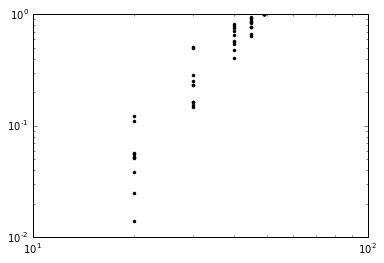

In [114]:
plt.loglog(50-rhovel_norm[0,:],rhovel_norm[1,:],'k.')

In [190]:
def fit_power(x, a, b):
    return a*(40-x)**b


In [191]:
w=np.where(rhovel_norm[0,:] <50)[0]

In [192]:
pa = curve_fit(fit_power, rhovel_norm[0,w], rhovel_norm[1,w])[0]

In [193]:
pa

array([  8.40171783e-04,   1.93592408e+00])

In [197]:
rh=np.linspace(0,35,100)

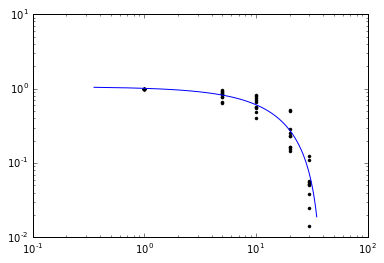

In [216]:
plt.loglog(rhovel_norm[0,:],rhovel_norm[1,:],'k.')
plt.loglog(rh,pa[0]*(40-rh)**pa[1])

In [46]:
np.shape(np.ones([1,i]))[1]

665

In [43]:
print(i)

665


In [58]:
np.shape(road[0,:i])

(665,)

In [59]:
np.shape(np.ones(1,i))

TypeError: data type not understood

In [140]:
ep=29/.1*(1-(4.5/58))**(-1.5)        

In [68]:
ep*(1-(x/self.R))**(1.5)

666